In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

Load the Ice Age data in the `genosnp` format:

In [3]:
genosnp = pd.concat([pd.read_table('../raw_data/ice_age/genosnp_first_500000.gz', sep=' ', header=None, na_values='-'),
                     pd.read_table('../raw_data/ice_age/genosnp_last_454456.gz', sep=' ', header=None, na_values='-')])
genosnp.columns = ['chrom', 'pos', 'id', 'genpos', 'allele0', 'allele1', 'bin', 'gt_string', 'bvalue']

Ignore sites that don't have a B-value annotation:

In [4]:
genosnp = genosnp.dropna()

# now that the NaNs are gone, bins can be integers
genosnp.bin = genosnp.bin.astype(int)

### Distribution of B-values of the archaic informative sites

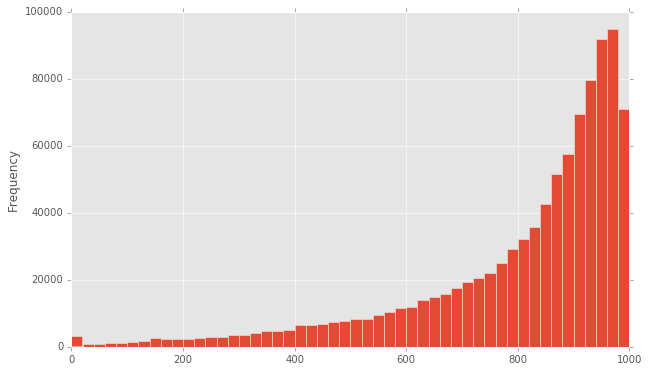

In [5]:
genosnp.bvalue.plot(kind='hist', xlim=(0, 1000), bins=50)

### Distribution of B-value bins, as binned by the Reich's lab

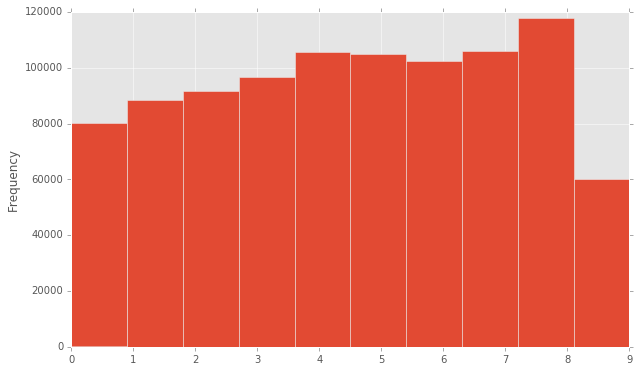

In [6]:
genosnp.bin.plot(kind='hist', xlim=(0, 9))

This distribution looks quite strange, as the sites were supposed to be binned into +/- equal-sizes bins?

What if we bin the sites ourselves? How does the distribution look like then?

In [7]:
n_bins = 10
bin_labels = list(range(n_bins))
our_bins = pd.qcut(genosnp.bvalue, n_bins, labels=bin_labels).astype(int)

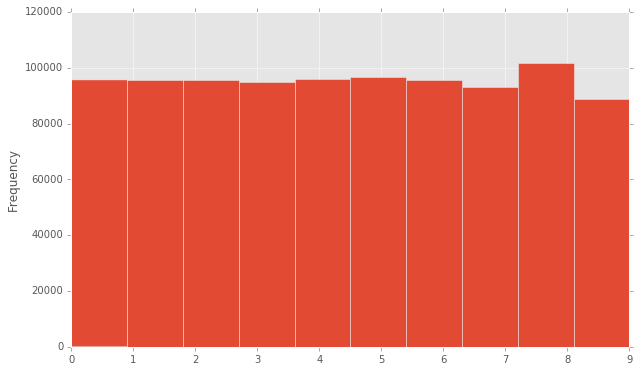

In [8]:
our_bins.plot(kind='hist', xlim=(0, 9))

I think I'm going to trust these bins a little bit more...